# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

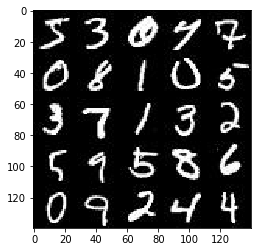

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

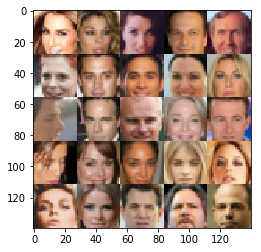

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learn_rate = tf.placeholder(tf.float32, name="lr")
    return r_inputs, z_data, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [4]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    n_units = 4 * 4 * 256
    alpha = 0.2
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    num_units = 7*7*512
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                           activation=None)
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [6]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, labels = tf.ones_like(disc_output_real) * (1 - smooth) )
    )
    
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.zeros_like(disc_output_fake) )
    )
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.ones_like(disc_output_fake) )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        return disc_train_opt, gen_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [9]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate} )
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate} )
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


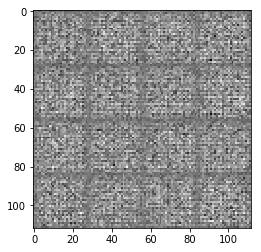

Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 3.4540
Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 3.8255
Epoch 1/2... Discriminator Loss: 0.5195... Generator Loss: 7.2154
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 5.0250
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 5.9956
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 4.4197
Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 7.6339
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 6.2587
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 6.4950
Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 6.3014


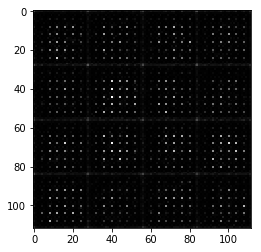

Epoch 1/2... Discriminator Loss: 0.3349... Generator Loss: 6.4264
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 7.2544
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 6.5773
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 6.8014
Epoch 1/2... Discriminator Loss: 0.3477... Generator Loss: 6.3633
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 6.6462
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 6.6530
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 7.0418
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 7.2208
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 2.9526


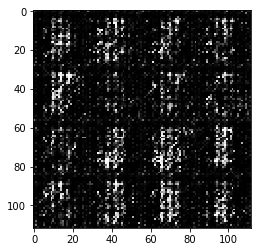

Epoch 1/2... Discriminator Loss: 3.9838... Generator Loss: 5.4602
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 2.5940
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.1965
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 2.4060
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 1.1455
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 2.2930
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 1.6867


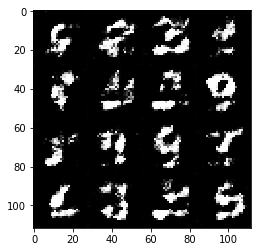

Epoch 1/2... Discriminator Loss: 1.6956... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 1.9295
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.6813
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 1.8269
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.7906


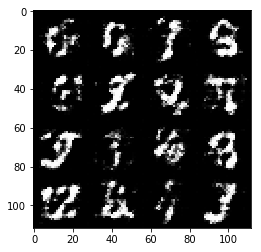

Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.4757
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.9115
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.4012
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 1.9848
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.2712
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.7149


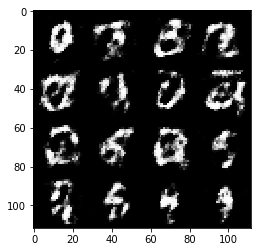

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.9715
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.0993
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 3.1824
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 1.9863
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 2.7807
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 0.7105... Generator Loss: 2.0203
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.4774
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 2.3423


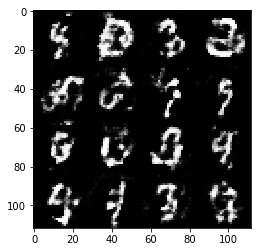

Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 2.2041
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 1.9154
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 2.2936
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 1.1457


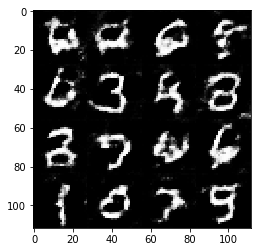

Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 1.7851
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.8751
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.3869
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.3544
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.1340


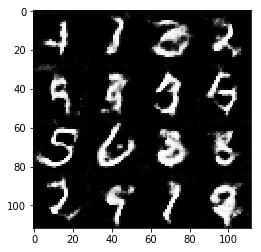

Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.2104
Epoch 1/2... Discriminator Loss: 0.7225... Generator Loss: 2.2855
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 1.4966
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.4601
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.4340
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.6978


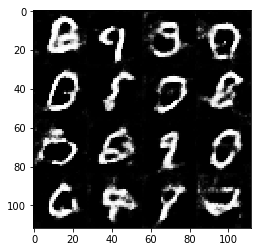

Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 1.1335
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 1.3739
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.3095
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 2.1414
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 1.4576
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.0310
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.9728


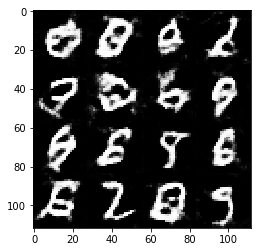

Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.9557
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.5121
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.3543
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.4495
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.9501
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.1861
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 1.2191


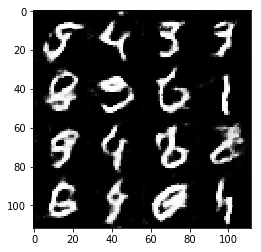

Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.6788
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 2.4071
Epoch 2/2... Discriminator Loss: 0.9083... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.3218
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.5221


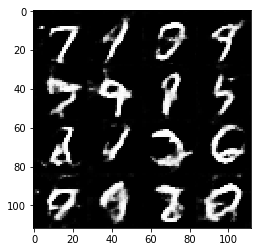

Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 2.5070
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 1.9895
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 2.0663
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 2.4191
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 2.1490


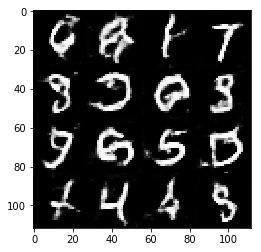

Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.8219
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 2.0395
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 2.7243
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 2.5252


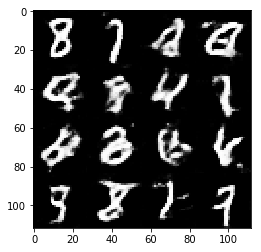

Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.4727
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.4111
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.6787
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.8163
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.6977
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.8126


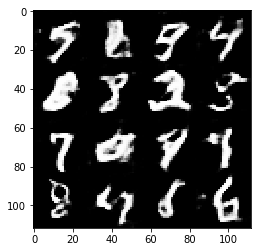

Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.8715
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 2.2873
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 2.0147
Epoch 2/2... Discriminator Loss: 1.8969... Generator Loss: 3.4656


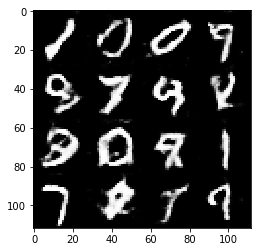

Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 1.2339
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.7828
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.8035
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.6858
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.5236
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 0.8333


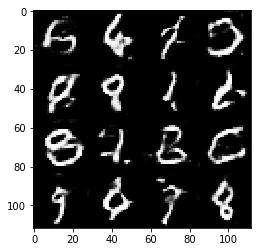

Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 2.0071
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.3207
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 0.6239... Generator Loss: 2.8158
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.1157


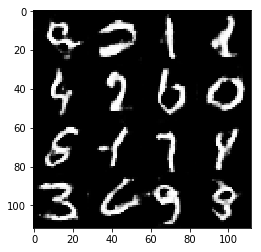

Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 1.6299
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.3958
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.7168
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.5734
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.7385
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.3378


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


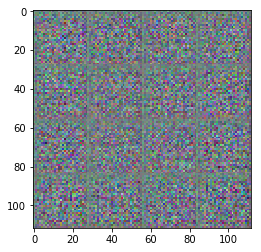

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.2501
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 2.4852
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 3.3918
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.8514
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 3.7061
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 4.3659
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.4804


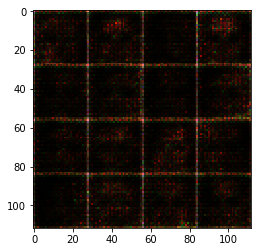

Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 5.3121
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.9619
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.6072
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.4557
Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 3.5967
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 7.3167
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.9290
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 3.5616


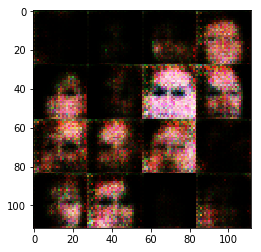

Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.3915
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.3725
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.8701
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 2.6721
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 2.7608
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.5055
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.0740
Epoch 1/1... Discriminator Loss: 2.8939... Generator Loss: 0.1759
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 2.6619
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8059


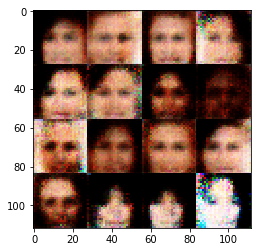

Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 2.4347
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.6574
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 2.1727
Epoch 1/1... Discriminator Loss: 2.3841... Generator Loss: 4.8795
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.5800
Epoch 1/1... Discriminator Loss: 2.2654... Generator Loss: 5.3537
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 3.1415


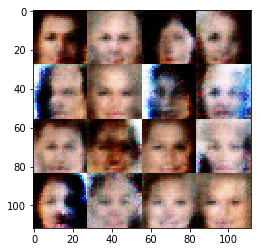

Epoch 1/1... Discriminator Loss: 2.2842... Generator Loss: 5.4967
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 4.2893
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 2.2418
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 2.5414
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7500


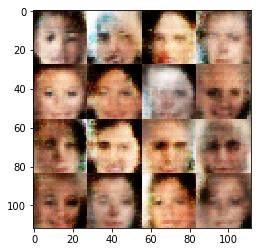

Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 2.2262
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.7624
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.5838
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 2.0248
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.5231
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.3145


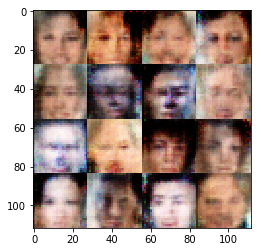

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 2.3354
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.0601


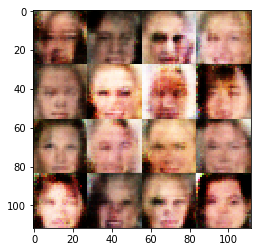

Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.6300
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.4506


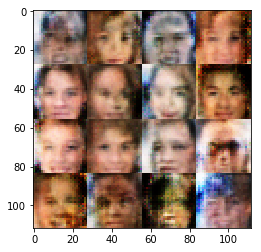

Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.3629
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7534


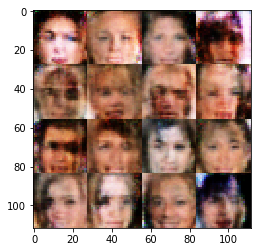

Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.5495
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.5561


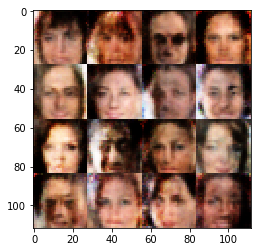

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.8901
Epoch 1/1... Discriminator Loss: 1.9902... Generator Loss: 0.2526
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.0822


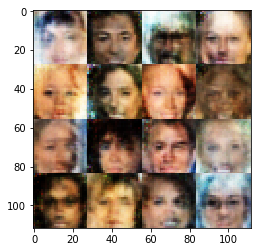

Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 3.4412... Generator Loss: 0.0845
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.2483


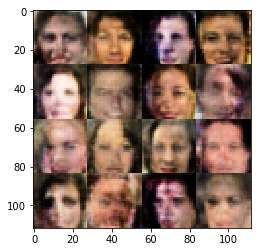

Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.5676


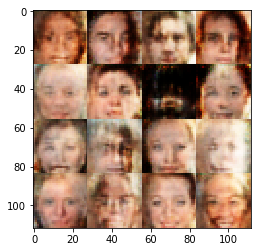

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.